In [1]:
get_ipython().system('pip install db-dtypes')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics

CONFIGURE THE BIGQUERY SETTINGS

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data` 
"""
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data.head()

uu_id  timeperiod  week_number  countyfips  \
0  f013068de98db1470bd986137a0c6d23    20220416           16       18003   
1  21957d5517323845818d87623589e1ba    20220319           12       18089   
2  6a5609f385912113b6f1014b958ed748    20220326           13       18089   
3  46b2882ec4c373527ec33f7bd4f1388d    20220716           29       18089   
4  37495d17e82f7df326bfc2c4c090f7b7    20220409           15       18089   

   tract                              tract_name  total_claims  \
0    900   Census Tract 9, Allen County, Indiana            22   
1  10400  Census Tract 104, Lake County, Indiana           111   
2  11500  Census Tract 115, Lake County, Indiana            39   
3  20700  Census Tract 207, Lake County, Indiana            14   
4  21900  Census Tract 219, Lake County, Indiana           155   

   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  ...  gender_female  \
0                0             <NA>                 14  ...           <NA>   
1                0             <NA>                108  ...             76   
2                0             <NA>               <NA>  ...           <NA>   
3                0             <NA>               <NA>  ...           <NA>   
4                0             <NA>                 69  ...             90   

   gender_male gender_na race_amerindian race_asian  race_black  \
0         <NA>         0               0          0          11   
1           35         0               0          0        <NA>   
2         <NA>         0               0          0          39   
3         <NA>         0               0       <NA>          10   
4           65         0               0          0         135   

   race_noanswer  race_hawaiiannative  race_other  race_white  
0              0                    0        <NA>        <NA>  
1           <NA>                    0           0           0  
2              0                    0           0           0  
3              0                    0        <NA>        <NA>  
4           <NA>                 <NA>        <NA>        <NA>  

[5 rows x 25 columns]

In [6]:
# Getting the no of columns to understand and choose the required ones
data.shape

(16833, 25)

inorder to know which columns are responsible or making a variation in predicting the unemployment claims,we need to find 
the correlation between them and drop the unnecessary colummns from the data frame.

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_16722/3188068582.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


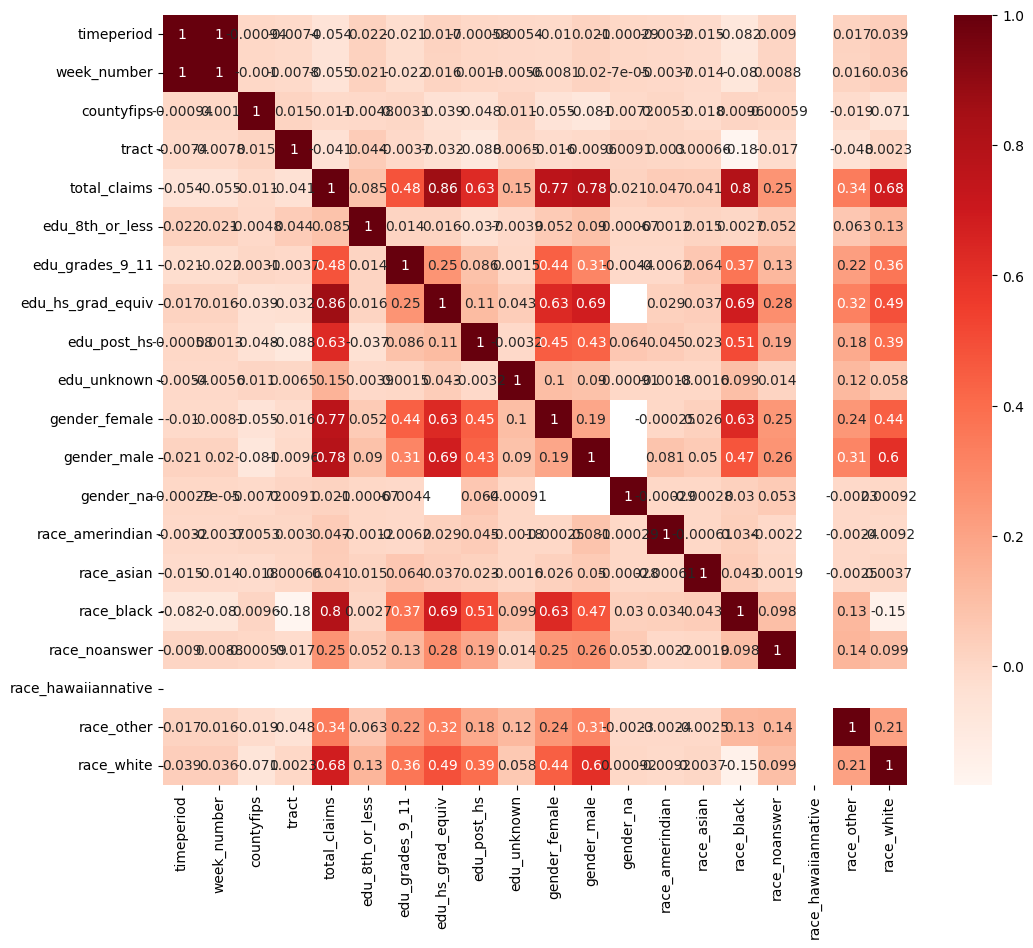

In [7]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [8]:
data['total_claims']
print("min",data['total_claims'].min(),"max",data['total_claims'].max())
print(data.columns)

min 10 max 170
Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [9]:
#Correlation with output variable
cor_target = abs(cor["total_claims"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

total_claims         1.000000
edu_hs_grad_equiv    0.863481
edu_post_hs          0.629552
gender_female        0.767174
gender_male          0.783093
race_black           0.795195
race_white           0.683659
Name: total_claims, dtype: float64


In [10]:
print(data.columns)
data=data[["uu_id","week_number","total_claims","edu_hs_grad_equiv","edu_post_hs","gender_female","gender_male","race_black","race_white"]]
data.columns
test=data

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [11]:
test=test.fillna(0,axis=0)
test["week_number"]= test["week_number"].astype("int")
test

uu_id  week_number  total_claims  \
0      f013068de98db1470bd986137a0c6d23           16            22   
1      21957d5517323845818d87623589e1ba           12           111   
2      6a5609f385912113b6f1014b958ed748           13            39   
3      46b2882ec4c373527ec33f7bd4f1388d           29            14   
4      37495d17e82f7df326bfc2c4c090f7b7           15           155   
...                                 ...          ...           ...   
16828  f35320206f3dd1ffc411e4ac127caf92           25            21   
16829  f35320206f3dd1ffc411e4ac127caf92           35            22   
16830  f35320206f3dd1ffc411e4ac127caf92           35            22   
16831  bbcb018f0e5e49e13636f6e78ce9f60f           13            53   
16832  bbcb018f0e5e49e13636f6e78ce9f60f           16            24   

       edu_hs_grad_equiv  edu_post_hs  gender_female  gender_male  race_black  \
0                     14            0              0            0          11   
1                    108            0             76           35           0   
2                      0            0              0            0          39   
3                      0            0              0            0          10   
4                     69           83             90           65         135   
...                  ...          ...            ...          ...         ...   
16828                  0           12              0            0           0   
16829                 13            0              0            0           0   
16830                 13            0              0            0           0   
16831                 48            0              0            0           0   
16832                 18            0             11           13           0   

       race_white  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
16828          14  
16829           0  
16830           0  
16831           0  
16832           0  

[16833 rows x 9 columns]

In [12]:
Using Linear regression model to predict from the data 

SyntaxError: invalid syntax (2835671989.py, line 1)

In [13]:
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data` 
"""
# QUERY THE DATA ONCE
query_job = bigquery_client.query(query)
data = query_job.to_dataframe()
data.head()

uu_id  timeperiod  week_number  countyfips  \
0  f013068de98db1470bd986137a0c6d23    20220416           16       18003   
1  21957d5517323845818d87623589e1ba    20220319           12       18089   
2  6a5609f385912113b6f1014b958ed748    20220326           13       18089   
3  46b2882ec4c373527ec33f7bd4f1388d    20220716           29       18089   
4  37495d17e82f7df326bfc2c4c090f7b7    20220409           15       18089   

   tract                              tract_name  total_claims  \
0    900   Census Tract 9, Allen County, Indiana            22   
1  10400  Census Tract 104, Lake County, Indiana           111   
2  11500  Census Tract 115, Lake County, Indiana            39   
3  20700  Census Tract 207, Lake County, Indiana            14   
4  21900  Census Tract 219, Lake County, Indiana           155   

   edu_8th_or_less  edu_grades_9_11  edu_hs_grad_equiv  ...  gender_female  \
0                0             <NA>                 14  ...           <NA>   
1                0             <NA>                108  ...             76   
2                0             <NA>               <NA>  ...           <NA>   
3                0             <NA>               <NA>  ...           <NA>   
4                0             <NA>                 69  ...             90   

   gender_male gender_na race_amerindian race_asian  race_black  \
0         <NA>         0               0          0          11   
1           35         0               0          0        <NA>   
2         <NA>         0               0          0          39   
3         <NA>         0               0       <NA>          10   
4           65         0               0          0         135   

   race_noanswer  race_hawaiiannative  race_other  race_white  
0              0                    0        <NA>        <NA>  
1           <NA>                    0           0           0  
2              0                    0           0           0  
3              0                    0        <NA>        <NA>  
4           <NA>                 <NA>        <NA>        <NA>  

[5 rows x 25 columns]

In [14]:
# Getting the no of columns to understand and choose the required ones
data.shape

(16833, 25)

inorder to know which columns are responsible or making a variation in predicting the unemployment claims,we need to find 
the correlation between them and drop the unnecessary colummns from the data frame.

/var/folders/l2/cnhff0_n1470l4xf0p7v7l_40000gn/T/ipykernel_16722/3188068582.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = data.corr()


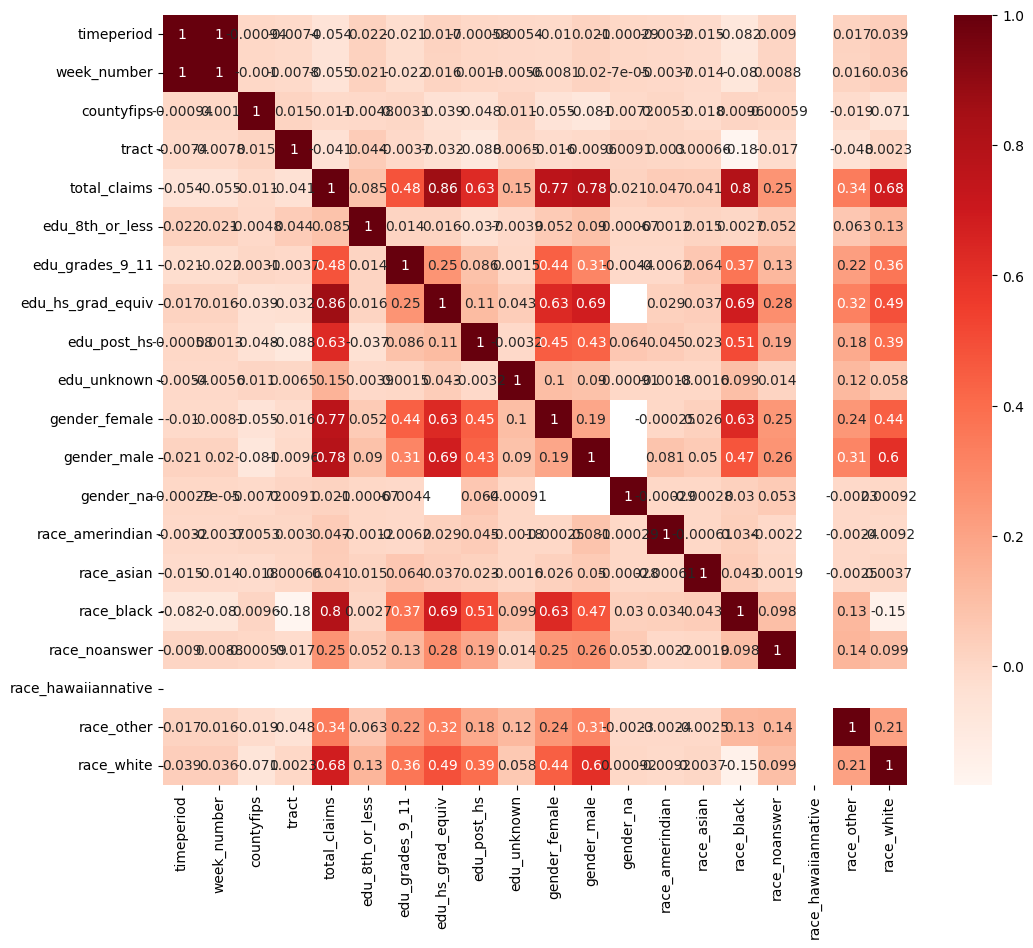

In [15]:
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [16]:
data['total_claims']
print("min",data['total_claims'].min(),"max",data['total_claims'].max())
print(data.columns)

min 10 max 170
Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [17]:
#Correlation with output variable
cor_target = abs(cor["total_claims"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print(relevant_features)

total_claims         1.000000
edu_hs_grad_equiv    0.863481
edu_post_hs          0.629552
gender_female        0.767174
gender_male          0.783093
race_black           0.795195
race_white           0.683659
Name: total_claims, dtype: float64


In [18]:
print(data.columns)
data=data[["uu_id","week_number","total_claims","edu_hs_grad_equiv","edu_post_hs","gender_female","gender_male","race_black","race_white"]]
data.columns
test=data

Index(['uu_id', 'timeperiod', 'week_number', 'countyfips', 'tract',
       'tract_name', 'total_claims', 'edu_8th_or_less', 'edu_grades_9_11',
       'edu_hs_grad_equiv', 'edu_post_hs', 'edu_unknown',
       'top_category_employer1', 'top_category_employer2',
       'top_category_employer3', 'gender_female', 'gender_male', 'gender_na',
       'race_amerindian', 'race_asian', 'race_black', 'race_noanswer',
       'race_hawaiiannative', 'race_other', 'race_white'],
      dtype='object')


In [19]:
test=test.fillna(0,axis=0)
test["week_number"]= test["week_number"].astype("int")
test

uu_id  week_number  total_claims  \
0      f013068de98db1470bd986137a0c6d23           16            22   
1      21957d5517323845818d87623589e1ba           12           111   
2      6a5609f385912113b6f1014b958ed748           13            39   
3      46b2882ec4c373527ec33f7bd4f1388d           29            14   
4      37495d17e82f7df326bfc2c4c090f7b7           15           155   
...                                 ...          ...           ...   
16828  f35320206f3dd1ffc411e4ac127caf92           25            21   
16829  f35320206f3dd1ffc411e4ac127caf92           35            22   
16830  f35320206f3dd1ffc411e4ac127caf92           35            22   
16831  bbcb018f0e5e49e13636f6e78ce9f60f           13            53   
16832  bbcb018f0e5e49e13636f6e78ce9f60f           16            24   

       edu_hs_grad_equiv  edu_post_hs  gender_female  gender_male  race_black  \
0                     14            0              0            0          11   
1                    108            0             76           35           0   
2                      0            0              0            0          39   
3                      0            0              0            0          10   
4                     69           83             90           65         135   
...                  ...          ...            ...          ...         ...   
16828                  0           12              0            0           0   
16829                 13            0              0            0           0   
16830                 13            0              0            0           0   
16831                 48            0              0            0           0   
16832                 18            0             11           13           0   

       race_white  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
16828          14  
16829           0  
16830           0  
16831           0  
16832           0  

[16833 rows x 9 columns]

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
model = LinearRegression()
X_train=test.drop(["uu_id"],axis=1)
X_train=X_train.loc[X_train["week_number"]<=33]
y=X_train["total_claims"]
X_test=test.drop(["uu_id"],axis=1)
X_test = X_test.loc[X_test["week_number"]==34]
temp=test.loc[test["week_number"]==34]

In [21]:
model.fit(X_train,y)

LinearRegression()

In [22]:
X_test = X_test.loc[X_test["week_number"]==34]
X_test.head(10)
temp

uu_id  week_number  total_claims  \
5      25a57fe39e03c632125308737a7d3769           34            24   
6      25a57fe39e03c632125308737a7d3769           34            24   
23     5e9480dba0f8de932f4d9fb55fa6b8b1           34            19   
26     5e9480dba0f8de932f4d9fb55fa6b8b1           34            19   
31     06e492b4f29d153af26c659d1f7da2a1           34            23   
...                                 ...          ...           ...   
16721  adef8f4cb061376c14393d4fb9ab3f89           34            13   
16740  447d5984bb8a8179bff002ccd1bba162           34            12   
16743  447d5984bb8a8179bff002ccd1bba162           34            12   
16809  06c78e49b4daedfeb808c42e58fb25e4           34            14   
16812  06c78e49b4daedfeb808c42e58fb25e4           34            14   

       edu_hs_grad_equiv  edu_post_hs  gender_female  gender_male  race_black  \
5                     15            0             14           10           0   
6                     15            0             14           10           0   
23                    10            0              0            0           0   
26                    10            0              0            0           0   
31                    15            0              0            0           0   
...                  ...          ...            ...          ...         ...   
16721                  0            0              0            0           0   
16740                  0            0              0            0           0   
16743                  0            0              0            0           0   
16809                  0            0              0            0           0   
16812                  0            0              0            0           0   

       race_white  
5               0  
6               0  
23              0  
26              0  
31             23  
...           ...  
16721           0  
16740          12  
16743          12  
16809           0  
16812           0  

[826 rows x 9 columns]

In [23]:
y_pred = model.predict(X_test)
y_pred

array([24., 24., 19., 19., 23., 23., 17., 17., 14., 14., 15., 15., 28.,
       28., 35., 35., 26., 26., 12., 12., 42., 42., 35., 35., 11., 11.,
       26., 26., 18., 18., 19., 19., 17., 17., 23., 23., 13., 13., 18.,
       18., 19., 19., 14., 14., 11., 11., 12., 12., 16., 16., 18., 18.,
       16., 16., 11., 11., 17., 17., 14., 14., 22., 22., 10., 10., 28.,
       28., 34., 34., 58., 58., 13., 13., 27., 27., 32., 32., 21., 21.,
       28., 28., 19., 19., 15., 15., 21., 21., 23., 23., 10., 10., 12.,
       12., 13., 13., 21., 21., 41., 41., 23., 23., 11., 11., 67., 67.,
       38., 38., 10., 10., 19., 19., 30., 30., 16., 16., 18., 18., 31.,
       31., 19., 19., 28., 28., 19., 19., 12., 12., 20., 20., 18., 18.,
       12., 12., 14., 14., 25., 25., 10., 10., 17., 17., 21., 21., 13.,
       13., 25., 25., 12., 12., 16., 16., 16., 16., 14., 14., 18., 18.,
       13., 13., 16., 16., 18., 18., 10., 10., 10., 10., 15., 15., 13.,
       13., 14., 14., 11., 11., 20., 20., 16., 16., 42., 42., 20

In [24]:
a=pd.DataFrame(data=temp)
a['count']=y_pred
a['count']=a['count'].astype('int')
a=a[['uu_id','week_number','count']]
a['week_number']=a['week_number']+1
a=a.rename(columns={'week_number':'week'})
a.to_string(index=False)

'                           uu_id  week  count\n25a57fe39e03c632125308737a7d3769    35     24\n25a57fe39e03c632125308737a7d3769    35     24\n5e9480dba0f8de932f4d9fb55fa6b8b1    35     18\n5e9480dba0f8de932f4d9fb55fa6b8b1    35     18\n06e492b4f29d153af26c659d1f7da2a1    35     23\n06e492b4f29d153af26c659d1f7da2a1    35     23\n98e63567a2f4907c9cb2637247651530    35     16\n98e63567a2f4907c9cb2637247651530    35     16\n592a852d462dffe18312976a3da5b7d8    35     13\n592a852d462dffe18312976a3da5b7d8    35     13\na21252ae119bf94fb9343a9d279b1f09    35     14\na21252ae119bf94fb9343a9d279b1f09    35     14\n8f782a6153268c6031e31784e2d4eae2    35     28\n8f782a6153268c6031e31784e2d4eae2    35     28\n5c04f20bd2f8552aa7ac210dc01292fb    35     35\n5c04f20bd2f8552aa7ac210dc01292fb    35     35\nd199aebcfab8dd5f47f9a2d645e5e25d    35     26\nd199aebcfab8dd5f47f9a2d645e5e25d    35     26\n07306ce64b3496b7955efaaf7509d73c    35     11\n07306ce64b3496b7955efaaf7509d73c    35     11\n44585653fcc9

In [25]:
a.to_csv("submission2.csv",index=False)
a

uu_id  week  count
5      25a57fe39e03c632125308737a7d3769    35     24
6      25a57fe39e03c632125308737a7d3769    35     24
23     5e9480dba0f8de932f4d9fb55fa6b8b1    35     18
26     5e9480dba0f8de932f4d9fb55fa6b8b1    35     18
31     06e492b4f29d153af26c659d1f7da2a1    35     23
...                                 ...   ...    ...
16721  adef8f4cb061376c14393d4fb9ab3f89    35     12
16740  447d5984bb8a8179bff002ccd1bba162    35     11
16743  447d5984bb8a8179bff002ccd1bba162    35     11
16809  06c78e49b4daedfeb808c42e58fb25e4    35     13
16812  06c78e49b4daedfeb808c42e58fb25e4    35     13

[826 rows x 3 columns]

In [26]:
y_true=test.loc[['week_number'==35]]

IndexError: Boolean index has wrong length: 1 instead of 16833

In [27]:
y_true=test.loc[test['week_number'==35]]

KeyError: False

In [28]:
test['week_number]

SyntaxError: EOL while scanning string literal (1922920482.py, line 1)

In [29]:
test['week_number']

0        16
1        12
2        13
3        29
4        15
         ..
16828    25
16829    35
16830    35
16831    13
16832    16
Name: week_number, Length: 16833, dtype: int64

In [30]:
y_true=test.loc[test['week_number']==35]

In [31]:
y_true=test.loc[test['week_number']==35]
y_true

uu_id  week_number  total_claims  \
65     66d134a595bd52251321d496ae2f4e0b           35            14   
66     66d134a595bd52251321d496ae2f4e0b           35            14   
79     1b7425c1ee8dc2465ef939286316744c           35            20   
80     1b7425c1ee8dc2465ef939286316744c           35            20   
106    98e63567a2f4907c9cb2637247651530           35            13   
...                                 ...          ...           ...   
16783  82b9ea58ff3d04a35df8deba80644a0e           35            17   
16789  124fe6d04692c372ffc4f84fc99f480d           35            15   
16790  124fe6d04692c372ffc4f84fc99f480d           35            15   
16829  f35320206f3dd1ffc411e4ac127caf92           35            22   
16830  f35320206f3dd1ffc411e4ac127caf92           35            22   

       edu_hs_grad_equiv  edu_post_hs  gender_female  gender_male  race_black  \
65                     0            0              0            0           0   
66                     0            0              0            0           0   
79                    12            0              0            0           0   
80                    12            0              0            0           0   
106                    0            0              0            0           0   
...                  ...          ...            ...          ...         ...   
16783                  0            0              0            0           0   
16789                  0            0              0            0           0   
16790                  0            0              0            0           0   
16829                 13            0              0            0           0   
16830                 13            0              0            0           0   

       race_white  
65             11  
66             11  
79             14  
80             14  
106            10  
...           ...  
16783           0  
16789           0  
16790           0  
16829           0  
16830           0  

[806 rows x 9 columns]

In [32]:
y_true=test.loc[test['week_number']==35]
MAE=metrics.mean_absolute_error(y_true,y_pred)
MSE=metrics.mean_squared_error(y_true,y_pred)
print(MAE)
MSE

ValueError: Found input variables with inconsistent numbers of samples: [806, 826]

In [33]:
y_true=test.loc[test['week_number']==35]
y_true.shape
MAE=metrics.mean_absolute_error(y_true,y_pred)
MSE=metrics.mean_squared_error(y_true,y_pred)
print(MAE)
MSE

ValueError: Found input variables with inconsistent numbers of samples: [806, 826]

In [34]:
y_true=test.loc[test['week_number']==35]
print(y_true.shape)
MAE=metrics.mean_absolute_error(y_true,y_pred)
MSE=metrics.mean_squared_error(y_true,y_pred)
print(MAE)
MSE

(806, 9)


ValueError: Found input variables with inconsistent numbers of samples: [806, 826]